# Hamiltonian Monte Carlo

As seen in previous notebooks, Metropolis sampler with proposals generated by random-walk has few (related) problems:
    - it fails in many dimensional problems
    - it often proposes states with low probability, resulting in high rejection rates

To solve these problems, sampling algorithm called Hamiltonian Monte Carlo was developed [ ]. There are two possible intuitive motivations for how it should work. One is purely abstract:

Random walk metropolis proposes unprobable states because the exploration of the state-space is *blind*- the proposal process is completely independent on the density distribution (only rejection-acceptance depends on it). We may solve this problem by taking the shape of the distribution into account when proposing states, for example by letting the gradient of the distribution guide us towards more probable states.
This motivation is explained in detail in [[1](https://arxiv.org/pdf/1701.02434.pdf)] (great paper, give it a try).

Another motivation is based on analogy with physics- ordinary physical systems are great at sampling from random distributions. For example a movement of an atom in a gas- its movement consists of two processes:
    - movement according to Newton's laws of motion under the influence of external potential field (completely deterministic).
    - random collisions with other particles in a gas
Position of this particle will be a random variable with distribution

$$ P(x) \propto e^{-\frac{U(x)}{T}}$$

where $U(x)$ is potential energy of the particle and $T$ temperature of the surrounding gass (governs how strong the random kicks from the collisions are). In physics this formula is called Boltzman (or Gibbs) distribution and is valid for all systems in thermal equilibrium, not just particle in a gas []. So the idea is this: let's divise such potential $U(x)$ that $P(x)$ will be our target distribution ( log probability unexpectedly appears here), simmulate the motion of the physical system with some random collisions added and we should get a decent sampler.

Both motivations would lead us to the same sampling algorith. In this notebook we will show one possible implementation of such sampler, introduce some theoretical concepts usefull for reasoning about it and try it on some problem where random walk metropolis fails.

## Hamiltonian Monte Carlo algorithm

HMC sampler algorithm works conceptually like this:

 - devise suitable (physical) system
 - at each step:
    - give the system random kick
    - simmulate its evolution for some predetermined time according to hamiltonian dynamics
    - correct numerical erros
    - return its position
    
### Simmulation of the time evolution of the system
The HMC is named by the fact that time evolution of the system is usually described using Hamiltonian formulation of classical mechanics. If a system has potential energy $U(x)$ and kinetic energy $K(x,p)$, it's total energy (also called hamiltonian) is $H=U(x)+K(x,p)$, where $x$ and $p$ are generalised position and momentum vectors (can be many dimensional). Then the equations of motion are:
 $$\begin{aligned}\dot{x} &= \frac{\partial \mathcal{H}}{\partial p} \\
\dot{p} &= - \frac{\partial \mathcal{H}}{\partial x}
\end{aligned}$$

Hamiltonian formulation is used because:
 - equations of motion have elegant symmetry that makes theoretical proofs easier
 - energy is natural concept in Hamiltonian formulation, which is good for us because potential energy corresponds directly to target probability distribution
 - it's easy to describe complicated many dimensional systems using this formalism

Good way to integrate these equations numerically is *leapfrog algorithm* []. It's based on this idea: if the algorithm for numerical integration of equations of motion is time reversible, then the integration preserves the total energy of the system, thus avoiding the slow creep away due to finite time step. Single step of leapfrog algorithm for the equations above (with time step $\delta$) looks like this:

 $$\begin{aligned} p(t+\frac{\delta}{2}) &= p(t)-\frac{\delta}{2} \frac{\partial H}{\partial x}\Bigr|_{t} \\
 x(t+\delta) &= x(t) + \delta \frac{\partial H}{\partial p}\Bigr|_{t+\frac{\delta}{2}}\\
 p(t+\delta) &= p(t+\frac{\delta}{2})-\frac{\delta}{2} \frac{\partial H}{\partial x}\Bigr|_{t+\delta}\end{aligned}$$

However, this algorithm doesn't prevent numerical errors due to rounding. This has to be corrected in another step of the HMC.



### Picking correct physical system ( = correct Hamiltonian)

How to choose hamiltonian which will lead to sampling from my target distribution?  Simplest hamiltonian is that of a single particle in a potential field:
$$H(x,v)=U(x)+\frac{1}{2}mv^2$$

TODO: is it the only possible Hamiltonian?

where we started to use velocity $v=\dot{x}=\frac{p}{m}$ instead of momentum. Remember that $x$ and $v$ can be many dimensional vectors (both with the same number of dimensions).
HMC with this hamiltonian will lead to probability distribution $ P(x)= \frac{1}{Z} e^{-\frac{U(x)}{T}}$, so if we set $T=1$, we  just have to choose U(x)=-log(P(x)) (normalization constant $Z$ can be safely left out, since it has no effect on the result). 

Equations of motion for this hamiltonian will be simply:

 $$\begin{aligned}\dot{x} &= v t \\
\dot{v} &= a= -\frac{1}{m} \frac{d U(x)}{d x}
\end{aligned}$$

, thus leading to numerical integration scheme (using leapfrog algorithm):

 $$\begin{aligned} v(t+\frac{\delta}{2}) &= v(t)+\frac{\delta}{2}a(t) \\
 x(t+\delta) &= x(t) + \delta v(t+\frac{\delta}{2})\\
 v(t+\delta) &= v(t+\frac{\delta}{2})+\frac{\delta}{2} a(t+\delta)\end{aligned}$$

So in order to use HMC, we will have to supply not only potential function, but also it's gradient (or compute it numerically).

### Random perturbations

Without some random perturbation of the system its evolution would be completely deterministic and thus useless for sampling. However, random perturbations must be such that they will lead to the correct sampling of $P(x)$. This will be satisfied if during each "random kick" step, we resample momentum from (Boltzman) probability distribution $P(p)=\frac{1}{Z} exp(-K(x,p)/T)$, where $T$ is temperature. Since we allready set $T=1$, for hamiltonian above we will sample velocity $v$ from distribution $P(v)=\frac{1}{Z}exp(-\frac{m v^2}{2})$, which is a normal distribution with variance $\sigma^2=\frac{1}{m}$.


### Correction of rounding errors

On a ideal machine, this step would not be necessary, but in reality numerical integration will introduce rounding errors which will in time bias the sampling. Turns out that this can be exactly corrected by adding a Metropolis accept/reject stage after the leapfrog integration [ ]. The proposed new state (x_{prop},p_{prop}) will be accepted with probability $$\frac{exp(-H(x_{prop},p_{prop}))}{exp(-H(x_{old},p_{old}))}$$. If it's not accepted, the system stays in its old state from before leapfrog integration. 

The fact that this is only correction step means that rejection should be rare and the **HMC should accept almost all proposed states**.

TODO: should it?

## Implementation

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

def target_distribution_to_potential(f, gradient_f):
    #doing it by hand is numerically more efficient,
    #but if you are lazy, here is a helper method
    potential=lambda x: -np.log(f(x))
    gradient= lambda x: -gradient_f(x)/f(x)
    return potential,gradient

class HMC_sampler:
    def __init__(self,
                 potential,
                 gradient,
                 num_leapfrog_steps=100,
                 leapfrog_stepsize=0.1,
                 mass=1.):   #inverse of variance of velocity distribution
        
        self.potential=potential
        self.gradient=gradient
        self.acceleration=lambda x: -gradient(x)/self.mass
        self.num_leapfrog_steps=num_leapfrog_steps
        self.leapfrog_stepsize=leapfrog_stepsize
        self.mass=mass
        
    def total_energy(self,x,v):
        return self.potential(x)+0.5*self.mass*np.dot(v,v)
        
    def do_leapfrog_step(self,x,v,a):       # a is for acceleration
        new_v= v + 0.5 * self.leapfrog_stepsize * a
        
        new_x= x + new_v * self.leapfrog_stepsize
        new_a=self.acceleration(new_x)
        
        new_v= new_v + 0.5 * self.leapfrog_stepsize * new_a
        return new_x,new_v,new_a
        
    def should_accept(self, energy, proposed_energy):    
        #since probability=exp(-energy), this is just metropolis criteria  
        u = np.random.uniform()
        return u < np.exp( energy - proposed_energy )    
    
    def sample_velocity(self,shape):
        return np.random.normal(0,(1./self.mass)**0.5,size=shape)
        
    def run(self,x_init,num_steps=1000):
        x_trace=np.zeros(shape=(num_steps,x_init.shape[0]))       
        x_trace[0,:]=x_init
        logs={'x':[],'v':[],'e':[],'rejected':[]}    #just for diagnostics purposes
        
        x=x_init
        for i in range(num_steps):
            #resample velocity (= random kick)
            v=self.sample_velocity(x_init.shape)

            #simulate hamiltonian dynamics with leapfrog algorithm
            #to get propossal values of x and v
            x_prop = x
            v_prop = v 
            a = self.acceleration(x)
            for n in range(self.num_leapfrog_steps):
                x_prop, v_prop, a = self.do_leapfrog_step(x_prop, v_prop,a)
                logs['x'].append(x_prop)
                logs['v'].append(v_prop)

            #accept or reject
            e = self.total_energy(x,v)
            e_prop = self.total_energy(x_prop,v_prop)
            #print e,e_prop

            logs['e'].append(e_prop)
            if self.should_accept(e,e_prop):
                x= x_prop
                e=e_prop
            else:
                logs['rejected'].append((x_prop,v_prop))
            x_trace[i,:]= x
        return x_trace,logs

Let's try to sample univariate normal distribution $P(x) = \frac{1}{\sqrt{\pi}} e^-x^2$ . Potential energy and it's gradient probability are:

In [2]:
def potential(x):
    return x**2    #So P(x)~exp(-potential(x))
def gradient(x):
    return 2*x

#number of leapfrog steps = 50, timestep = 0.1 and m=1 
sampler=HMC_sampler(potential,gradient,num_leapfrog_steps=50,leapfrog_stepsize=0.1,mass=1)

In [3]:
# sample 500 samples, with initial position x=0
x_trace,logs=sampler.run(np.array([0.]),500)

<IPython.core.display.Javascript object>


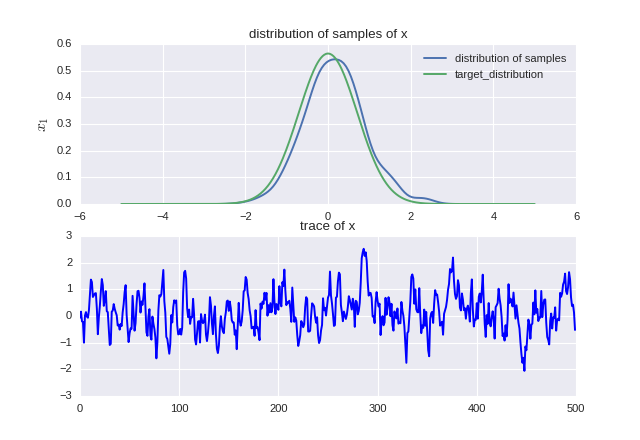

number of rejected samples:  1


In [4]:
import seaborn as sns

plt.figure()
plt.subplot(2,1,1)
sns.kdeplot(x_trace[:,0],label='distribution of samples')
plt.plot(np.linspace(-5,5,500),np.exp(-np.linspace(-5,5,500)**2)/(np.pi)**0.5,label='target_distribution')
plt.title('distribution of samples of x')
plt.ylabel('$x_1$', fontsize=14)
plt.legend()
plt.subplot(2,1,2)
plt.plot(x_trace, 'b-')
plt.title('trace of x')

print "number of rejected samples: ",len(logs['rejected']) 

Have a look at the number of rejected samples. Play around with the three parameters that can be tweaked
 - mass (the bigger the mass, the smaller the kicks => slower exploration of the state space)
 - number of leapfrog steps
 - size of leapfrog step
 
and see what happens.


Also have a look at the values of $x$ through which the system passed during leapfrog integration.
Can you explain why it looks like it does? What about energy log (```logs["e"]```)?

rejected samples: 1


<IPython.core.display.Javascript object>


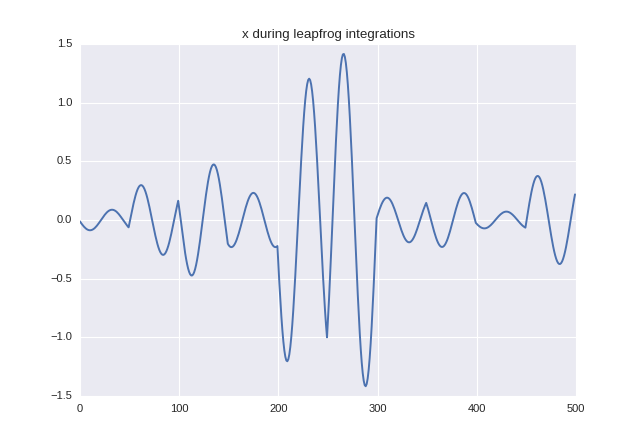

In [5]:
#number of rejected samples:
print 'rejected samples:', len(logs['rejected'])

plt.figure()
plt.plot(logs['x'][:500])
plt.title('x during leapfrog integrations')

Let's try some more complicated distribution, which could be difficult to sample by random walk Metropolis.

TODO: comparision

<IPython.core.display.Javascript object>


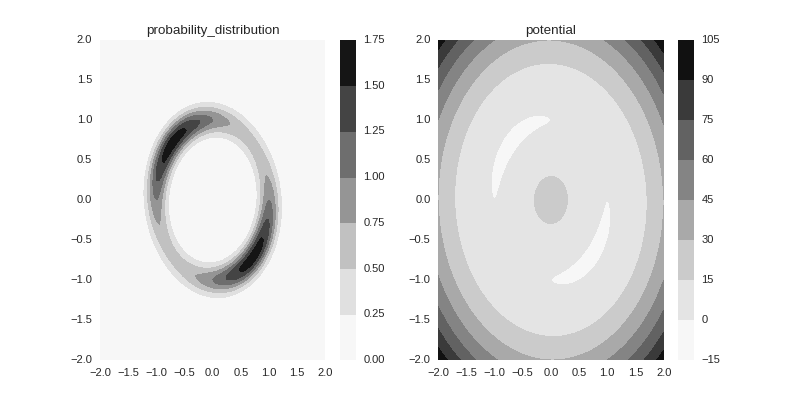

/usr/local/lib/python2.7/dist-packages/numpy-1.13.1-py2.7-linux-x86_64.egg/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python2.7/dist-packages/numpy-1.13.1-py2.7-linux-x86_64.egg/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


In [6]:
a=30.
b=0.5

def fancy_potential(x):
    r=np.dot(x,x)**0.5
    if r<0.1:      #potential numerical instability?
        return a*(r-1)**2
    return a*(r-1)**2+2*b*x[0]*x[1]/r  #=a(r-1)**2+b*sin(2*phi)*r

def fancy_gradient(x):
    r=np.dot(x,x)**0.5
    if r<0.1:
        return 0.
    dUdx=2*a*(r-1)*x[0]/r+2*b*x[1]*(1/r-x[0]**2/r**3)
    dUdy=2*a*(r-1)*x[1]/r+2*b*x[0]*(1/r-x[1]**2/r**3)
    return np.array([dUdx,dUdy])

xg, yg = np.meshgrid(np.linspace(-2,2,100), np.linspace(-2,2,100))
zg = np.zeros_like(xg)
for i,j in np.ndindex(xg.shape):
    zg[i,j] = fancy_potential(np.array([xg[i,j], yg[i,j]]))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot1=plt.contourf(xg, yg, np.exp(-zg))
plt.colorbar(plot1)
plt.title('probability_distribution')
plt.subplot(1,2,2)
plot2=plt.contourf(xg, yg, zg)
plt.colorbar(plot2)
plt.title('potential')

In [7]:
fancy_potential(np.array([0.2,0.2]))

15.570858607760165

In [8]:
#number of leapfrog steps = 20, timestep = 0.1 and m=10 
sampler=HMC_sampler(fancy_potential,fancy_gradient,
                    num_leapfrog_steps=20,
                    leapfrog_stepsize=0.1,
                    mass=10.)   
x_init=np.array([0.,0.])
x_trace,logs=sampler.run(x_init,1000)
print 'rejected: ', len(logs['rejected'])

rejected:  3


<IPython.core.display.Javascript object>


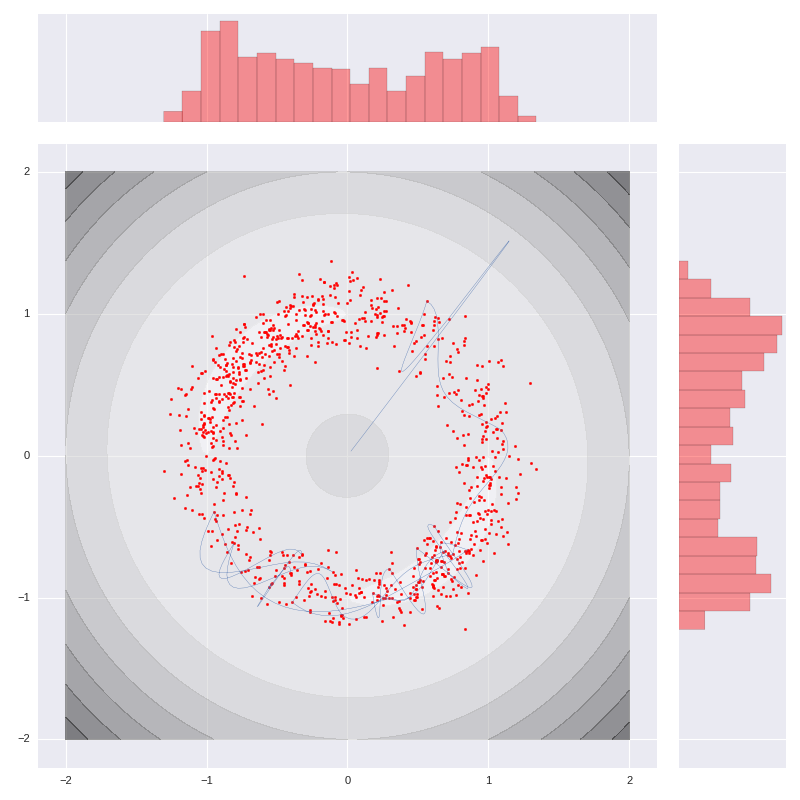

In [9]:
g = sns.JointGrid(x=x_trace[:,0], y=x_trace[:,1], size=10)
g.ax_joint.contourf(xg, yg, zg, alpha=0.5)
g = g.plot_joint(plt.scatter, color="r",marker='.')
_ = g.ax_marg_x.hist(x_trace[:,0], color="r", alpha=.4, bins=20)
_ = g.ax_marg_y.hist(x_trace[:,1], color="r", alpha=.4, bins=20, orientation="horizontal")
x,y=zip(*logs['x'][:20*20])    #path of the first 20 leapfrog simmulations
plt.plot(x,y,linewidth=0.3)

TODO: what's above, some discussion of when HMC is and isn't good (what about many dimensions), how to setup free parameters, why mass instead of temperature (and why it isn't in other papers), add citations.